In [30]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from DeepPeak.signals import generate_gaussian_dataset
from DeepPeak.utils.visualization import plot_training_history, SignalPlotter
from DeepPeak.models import build_ROI_model, permutation_invariant_loss
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [72]:
SEQUENCE_LENGTH = 400
MAX_PEAKS = 3
WIDTH = 0.05

In [95]:
signals, true_amplitudes, positions, _, x_values, num_peaks = generate_gaussian_dataset(
    n_samples=20_000,
    sequence_length=SEQUENCE_LENGTH,
    n_peaks=(1, MAX_PEAKS),
    amplitude=(1, 50),
    position=(0.1, 0.9),
    width=(WIDTH, WIDTH),
    noise_std=0.01,
    categorical_peak_count=False,
)

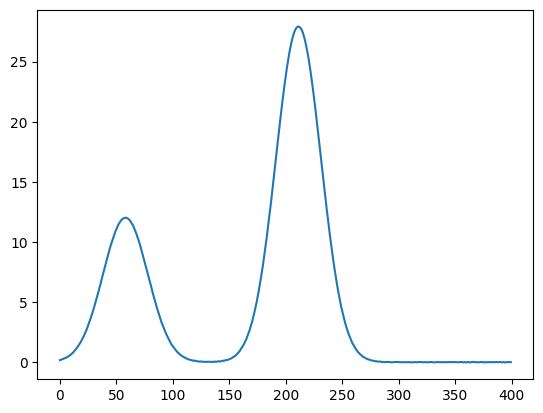

In [96]:
idx = np.random.randint(100)
plt.figure()
plt.plot(signals[idx])
plt.show()

In [97]:
def compute_measured_amplitude(signal, x_values, peak_pos):
    nearest_idx = np.argmin(np.abs(x_values - peak_pos))
    return signal[nearest_idx]


def generate_dataset_DP(n_samples, max_peaks, width):
    signals, true_amplitudes, positions, _, x_values, num_peaks = generate_gaussian_dataset(
        n_samples=n_samples,
        sequence_length=SEQUENCE_LENGTH,
        n_peaks=(0, max_peaks),
        amplitude=(1, 100),
        position=(0.0, 1.0),
        width=(width, width),
        noise_std=0.01,
        categorical_peak_count=False,
    )
    
    X = []
    y = []
    measured_amplitudes = []
    for i in range(n_samples):
        signal = signals[i]               
        pos = positions[i]               
        amps = true_amplitudes[i]         
        n_peaks = int(num_peaks[i])
        measured = np.zeros(max_peaks)

        for j in range(n_peaks):
            measured[j] = compute_measured_amplitude(signal, x_values, pos[j])

        measured_amplitudes.append(measured)

        sample_input = np.concatenate([pos, measured])
        X.append(sample_input)
        y.append(amps)
    return np.array(X), np.array(y), signals, positions, true_amplitudes, np.array(measured_amplitudes)

In [98]:
def build_model(input_dim, output_dim):
    # Here, we assume that the input is a concatenation of positions and measured amplitudes.
    # For example, if max_pulses = 4 then input_dim = 8 and the first 4 elements are positions,
    # and the next 4 elements are measured amplitudes.
    max_pulses = output_dim  # number of peaks

    # Define the input
    inputs = keras.Input(shape=(input_dim,))

    # Split the input into two branches:
    # Branch 1: positions (first max_pulses values)
    pos = layers.Lambda(lambda x: x[:, :max_pulses])(inputs)
    # Branch 2: measured amplitudes (last max_pulses values)
    meas = layers.Lambda(lambda x: x[:, max_pulses:])(inputs)

    # Process the positions branch.
    x1 = layers.Dense(128, activation='relu')(pos)
    x1 = layers.BatchNormalization()(x1)
    x1 = layers.Dropout(0.2)(x1)
    x1 = layers.Dense(64, activation='relu')(x1)
    x1 = layers.BatchNormalization()(x1)
    
    # Process the measured amplitudes branch.
    x2 = layers.Dense(128, activation='relu')(meas)
    x2 = layers.BatchNormalization()(x2)
    x2 = layers.Dropout(0.2)(x2)
    x2 = layers.Dense(64, activation='relu')(x2)
    x2 = layers.BatchNormalization()(x2)
    
    # Merge the two branches.
    merged = layers.concatenate([x1, x2])
    x = layers.Dense(128, activation='relu')(merged)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(64, activation='relu')(x)
    
    # Output layer: predict the true amplitudes (one per peak).
    outputs = layers.Dense(output_dim, activation='linear')(x)
    
    model = keras.Model(inputs=inputs, outputs=outputs)
    optimizer = keras.optimizers.Adam(learning_rate=1e-3)
    model.compile(optimizer=optimizer, loss='mse')
    return model

Epoch 1/80
438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 908us/step - loss: 657.6425 - val_loss: 81.1351 - learning_rate: 0.0010
Epoch 2/80
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 761us/step - loss: 109.9865 - val_loss: 58.1197 - learning_rate: 0.0010
Epoch 3/80
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 863us/step - loss: 95.4087 - val_loss: 52.8004 - learning_rate: 0.0010
Epoch 4/80
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 762us/step - loss: 84.6665 - val_loss: 42.9634 - learning_rate: 0.0010
Epoch 5/80
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 763us/step - loss: 80.2647 - val_loss: 40.5817 - learning_rate: 0.0010
Epoch 6/80
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 762us/step - loss: 76.1807 - val_loss: 36.6519 - learning_rate: 0.0010
Epoch 7/80
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 767us/step - loss: 72.9349 - val_loss: 36.9964 - learning_rate: 0.0010
Epoch 8/80
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step - loss: 69.6319 - val_loss: 37.9803 - learning_rate: 0.0010
Epoch 9/80
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 762us/step - loss: 70.0223 - val_loss: 35.1

/Users/m.poinsinetdesivry-houle/Desktop/GitRepositories/DeepPeak/DeepPeak/utils/visualization.py:207: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='upper left')


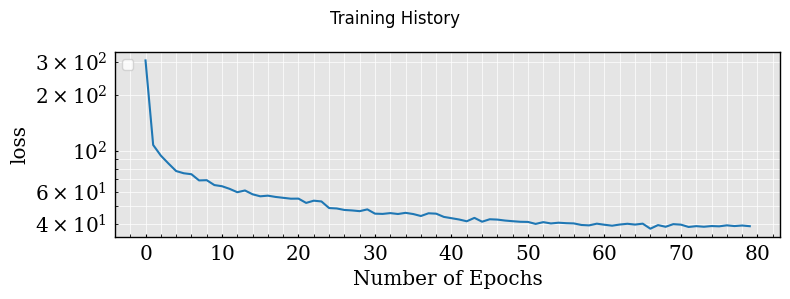

In [99]:
lr_scheduler = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)

X_train, y_train, _, _, _, _ = generate_dataset_DP(
    n_samples=20_000, 
    max_peaks=MAX_PEAKS, 
    width=WIDTH
)

model = build_model(input_dim=2 * MAX_PEAKS, output_dim=MAX_PEAKS)

history = model.fit(
    X_train, y_train,
    epochs=80,
    batch_size=32,
    validation_split=0.3,
    verbose=1,
    callbacks=[lr_scheduler]
)

plot_training_history(history)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


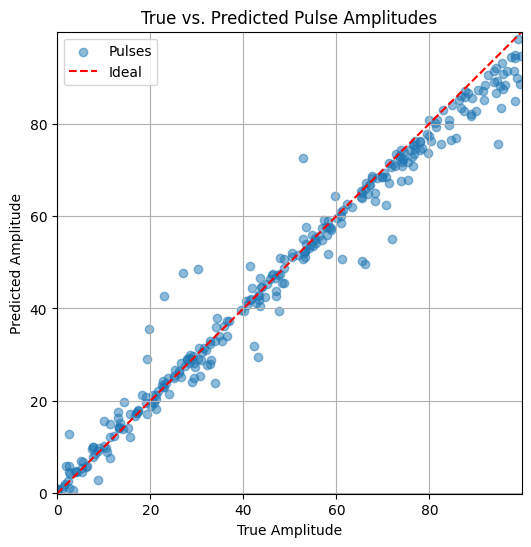

In [102]:
X_val, y_val, _, _, _, _ = generate_dataset_DP(
    n_samples=2_00,
    max_peaks=MAX_PEAKS, 
    width=WIDTH
)

y_pred = model.predict(X_val)

true_vals = []
pred_vals = []
for sample_true, sample_pred in zip(y_val, y_pred):
    sample_true = np.sort(sample_true)
    sample_pred = np.sort(sample_pred)

    for true_amp, pred_amp in zip(sample_true, sample_pred):
        if pred_amp > 0.5:  # if the pulse is present
            true_vals.append(true_amp)
            pred_vals.append(pred_amp)
            
true_vals = np.array(true_vals)
pred_vals = np.array(pred_vals)


plt.figure(figsize=(6, 6))
plt.scatter(true_vals, pred_vals, alpha=0.5, label='Pulses')
# Plot the identity line for reference
lims = [
    min(true_vals.min(), pred_vals.min()) - 0.1, max(true_vals.max(), pred_vals.max()) + 0.1
]
plt.plot(lims, lims, 'r--', label='Ideal')
plt.xlabel("True Amplitude")
plt.ylabel("Predicted Amplitude")
plt.title("True vs. Predicted Pulse Amplitudes")
plt.legend()
plt.xlim(lims)
plt.ylim(lims)
plt.grid(True)
plt.show()


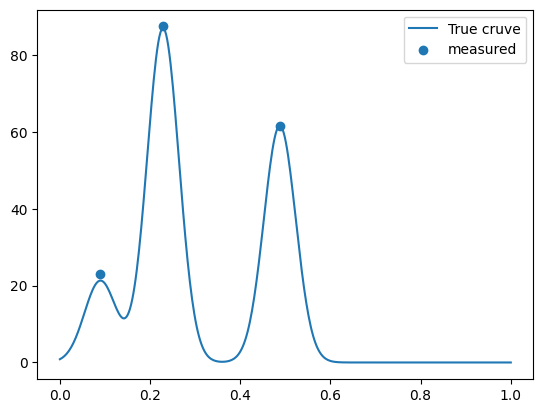

In [84]:
idx = np.random.randint(100)
p0, p1, p2, m0, m1, m2 = X_val[idx]
amp0, amp1, amp2 = y_val[idx]

x = np.linspace(0, 1, SEQUENCE_LENGTH)
curve = np.zeros_like(x)
for position, amplitude in zip((p0, p1, p2), (amp0, amp1, amp2)):
    curve += amplitude * np.exp(-(x - position)**2 / WIDTH ** 2)

plt.figure()
plt.plot(x, curve, label='True cruve')
plt.scatter((p0, p1, p2), (m0, m1, m2), label='measured')
plt.legend()
plt.show()

In [44]:
import numpy as np

def compute_true_amplitudes(positions, measured, sigma):
    """
    Compute the true amplitudes given the positions, measured amplitudes,
    and known Gaussian width sigma.

    Parameters:
      positions : 1D numpy array of shape (N,)
                  Valid pulse positions.
      measured  : 1D numpy array of shape (N,)
                  Measured amplitudes at the corresponding positions.
      sigma     : float
                  The standard deviation (width) of the Gaussian pulses.

    Returns:
      true_amplitudes : 1D numpy array of shape (N,)
                        Computed true amplitudes.
    """
    N = len(positions)
    # Build the kernel matrix K of shape (N, N)
    K = np.zeros((N, N))
    for j in range(N):
        for i in range(N):
            K[j, i] = np.exp(-((positions[j] - positions[i])**2) / (2 * sigma**2))
    
    # Solve for the true amplitudes: K * A = measured => A = K^{-1} * measured
    true_amplitudes = np.linalg.solve(K, measured)
    return true_amplitudes

# Example usage:
if __name__ == '__main__':
    # Assume we have three pulses with known positions:
    positions = np.array([0.2, 0.5, 0.8])
    sigma = 0.05

    # For demonstration, suppose these are the measured amplitudes.
    # In a noise-free model, measured amplitudes are given by:
    # m_j = sum_i A_i * exp(-((p_j-p_i)^2)/(2*sigma^2))
    measured = np.array([10, 15, 12])  # example measured values

    # Compute the true amplitudes
    true_amplitudes = compute_true_amplitudes(positions, measured, sigma)
    print("Computed true amplitudes:", true_amplitudes)


Computed true amplitudes: [ 9.99999977 14.99999966 11.99999977]
